In [1]:
#Importando bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
import plotnine as p9
import pmdarima as pmd
import xgboost as xgb
from nixtlats import TimeGPT
from scipy.stats import norm 

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Visulizando o dataset
df = pd.read_csv('https://raw.githubusercontent.com/Andressaach/Previsao-de-precos-da-cesta-basica/main/dados_cesta_basica_fb.csv')
df

,data,valor,IPCA,arroz,feijao,acucar,café,farinha_de_trigo,batata,banana,tomate,margarina,pao,oleo_de_soja,leite,carne
0,2014-01-01,251.19,0.55,6.32,18.26,4.45,4.19,2.85,9.81,13.33,18.84,3.17,34.76,2.77,16.25,111.97
1,2014-02-01,250.84,0.69,6.56,17.79,4.40,4.10,3.11,11.69,11.05,19.77,2.36,33.05,2.78,15.60,118.52
2,2014-03-01,275.40,0.92,6.44,18.58,4.50,4.12,3.00,17.16,15.78,32.77,2.30,34.18,2.96,16.26,117.34
3,2014-04-01,285.03,0.67,6.58,19.01,4.54,4.25,3.06,20.15,16.81,25.57,2.32,31.93,3.10,17.54,130.19
4,2014-05-01,279.20,0.46,6.58,18.26,4.62,4.13,3.11,13.63,14.66,33.26,2.29,32.12,2.79,17.34,126.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-09-01,566.90,0.26,15.55,30.68,11.29,17.60,5.94,16.19,29.79,68.58,10.06,53.29,5.39,34.00,268.63
117,2023-10-01,578.40,0.24,16.58,30.83,11.58,17.16,5.76,24.08,27.59,66.87,9.98,54.77,5.39,32.66,275.16
118,2023-11-01,576.69,0.28,16.82,33.20,11.94,16.92,5.74,27.29,29.32,52.40,10.45,57.27,5.64,31.17,278.54
119,2023-12-01,608.89,0.56,17.31,38.46,11.52,17.66,5.73,37.84,30.44,63.67,9.53,58.18,5.75,31.09,281.73


In [3]:
#Visuzalizando informações do dataset para verificar os tipos de variáveis e se há dados nulos 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121 entries, 0 to 120
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   data              121 non-null    object 
 1   valor             121 non-null    float64
 2   IPCA              121 non-null    float64
 3   arroz             121 non-null    float64
 4   feijao            121 non-null    float64
 5   acucar            121 non-null    float64
 6   café              121 non-null    float64
 7   farinha_de_trigo  121 non-null    float64
 8   batata            121 non-null    float64
 9   banana            121 non-null    float64
 10  tomate            121 non-null    float64
 11  margarina         121 non-null    float64
 12  pao               121 non-null    float64
 13  oleo_de_soja      121 non-null    float64
 14  leite             121 non-null    float64
 15  carne             121 non-null    float64
dtypes: float64(15), object(1)
memory usage: 15.3

In [4]:
df['data'] = pd.to_datetime(df['data'])

In [5]:
# Criando um novo df com a série deflacionada

# definindo a coluna 'data' como índice do dataframe
df.set_index('data', inplace=True)

# Função para deflacionar os valores com base na coluna IPCA
def deflacionar_coluna(coluna):
    return coluna / (1 + df['IPCA'] / 100)

# Criando um novo DataFrame deflacionado
df_deflacionado = pd.DataFrame(index=df.index)

# Iterando sobre as colunas e deflacionando os valores da coluna 'valor'
for coluna in df.columns:
    if coluna != 'IPCA':  # Ignorando a coluna IPCA
        df_deflacionado[coluna] = deflacionar_coluna(df[coluna]).round(2)

# Exibindo o DataFrame deflacionado
print(df_deflacionado)

             valor  arroz  feijao  acucar   café  farinha_de_trigo  batata  \
data                                                                         
2014-01-01  249.82   6.29   18.16    4.43   4.17              2.83    9.76   
2014-02-01  249.12   6.52   17.67    4.37   4.07              3.09   11.61   
2014-03-01  272.89   6.38   18.41    4.46   4.08              2.97   17.00   
2014-04-01  283.13   6.54   18.88    4.51   4.22              3.04   20.02   
2014-05-01  277.92   6.55   18.18    4.60   4.11              3.10   13.57   
...            ...    ...     ...     ...    ...               ...     ...   
2023-09-01  565.43  15.51   30.60   11.26  17.55              5.92   16.15   
2023-10-01  577.02  16.54   30.76   11.55  17.12              5.75   24.02   
2023-11-01  575.08  16.77   33.11   11.91  16.87              5.72   27.21   
2023-12-01  605.50  17.21   38.25   11.46  17.56              5.70   37.63   
2024-01-01  602.50  18.13   40.79   11.47  16.96              5.

In [6]:
#obtendo estatísticas básicas dos dados
print(df_deflacionado.describe().round(2))

        valor   arroz  feijao  acucar    café  farinha_de_trigo  batata  \
count  121.00  121.00  121.00  121.00  121.00            121.00  121.00   
mean   402.13    9.66   23.74    7.14   11.88              3.88   17.35   
std    114.72    3.16    7.10    2.43    4.32              1.26    7.06   
min    249.12    6.14   13.81    4.12    4.07              2.50    5.52   
25%    311.55    7.25   17.31    5.36   10.17              2.95   12.22   
50%    344.94    8.16   21.07    6.38   11.23              3.33   15.84   
75%    498.99   12.44   30.29    9.62   12.64              4.59   21.44   
max    605.50   18.13   40.79   11.91   20.33              6.57   41.69   

       banana  tomate  margarina     pao  oleo_de_soja   leite   carne  
count  121.00  121.00     121.00  121.00        121.00  121.00  121.00  
mean    19.05   36.02       6.57   42.04          4.57   24.74  195.54  
std      6.63   13.52       2.61    6.23          2.05    7.41   62.60  
min      8.46   13.91       2.25

## Criando visualizações

In [7]:
df_deflacionado.reset_index(inplace=True)
df_deflacionado

,data,valor,arroz,feijao,acucar,café,farinha_de_trigo,batata,banana,tomate,margarina,pao,oleo_de_soja,leite,carne
0,2014-01-01,249.82,6.29,18.16,4.43,4.17,2.83,9.76,13.26,18.74,3.15,34.57,2.75,16.16,111.36
1,2014-02-01,249.12,6.52,17.67,4.37,4.07,3.09,11.61,10.97,19.63,2.34,32.82,2.76,15.49,117.71
2,2014-03-01,272.89,6.38,18.41,4.46,4.08,2.97,17.00,15.64,32.47,2.28,33.87,2.93,16.11,116.27
3,2014-04-01,283.13,6.54,18.88,4.51,4.22,3.04,20.02,16.70,25.40,2.30,31.72,3.08,17.42,129.32
4,2014-05-01,277.92,6.55,18.18,4.60,4.11,3.10,13.57,14.59,33.11,2.28,31.97,2.78,17.26,125.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,2023-09-01,565.43,15.51,30.60,11.26,17.55,5.92,16.15,29.71,68.40,10.03,53.15,5.38,33.91,267.93
117,2023-10-01,577.02,16.54,30.76,11.55,17.12,5.75,24.02,27.52,66.71,9.96,54.64,5.38,32.58,274.50
118,2023-11-01,575.08,16.77,33.11,11.91,16.87,5.72,27.21,29.24,52.25,10.42,57.11,5.62,31.08,277.76
119,2023-12-01,605.50,17.21,38.25,11.46,17.56,5.70,37.63,30.27,63.32,9.48,57.86,5.72,30.92,280.16


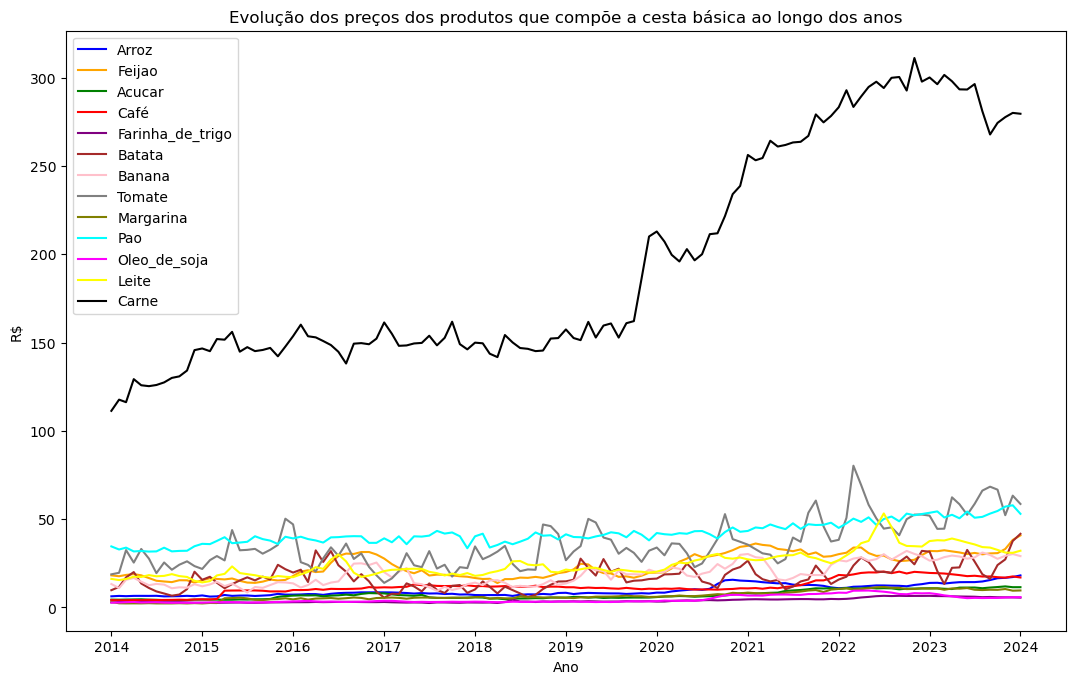

In [8]:
fig = plt.figure(figsize=(10, 6))
eixo = fig.add_axes([0, 0, 1, 1])

# Definindo cores para cada série temporal
cores = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'black']

colunas = ['arroz', 'feijao', 'acucar', 'café', 'farinha_de_trigo', 'batata', 'banana', 'tomate', 'margarina', 'pao', 'oleo_de_soja', 'leite', 'carne']

for i, coluna in enumerate(colunas, start=0):
    eixo.plot(df_deflacionado['data'], df_deflacionado[coluna], linestyle='-', color=cores[i], label=coluna.capitalize())

plt.title('Evolução dos preços dos produtos que compõe a cesta básica ao longo dos anos')
plt.xlabel('Ano')
plt.ylabel('R$')
plt.legend()
plt.show()

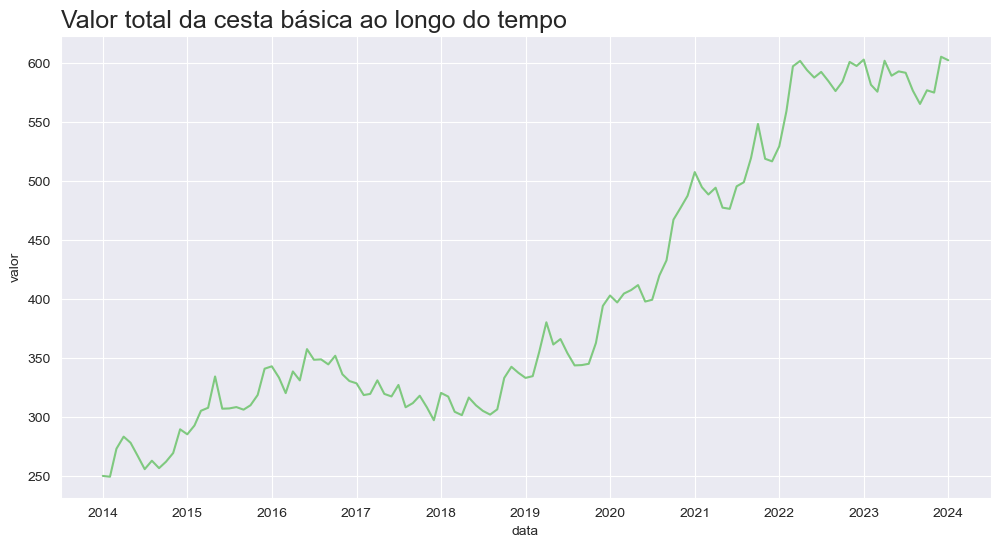

In [9]:
sns.set_palette('Accent')
sns.set_style('darkgrid')

# Plotagem do gráfico de linha
ax = sns.lineplot(x='data', y='valor', data=df_deflacionado)

# Definindo tamanho e título do gráfico
ax.figure.set_size_inches(12, 6)
ax.set_title('Valor total da cesta básica ao longo do tempo', loc='left', fontsize=18)

plt.show()

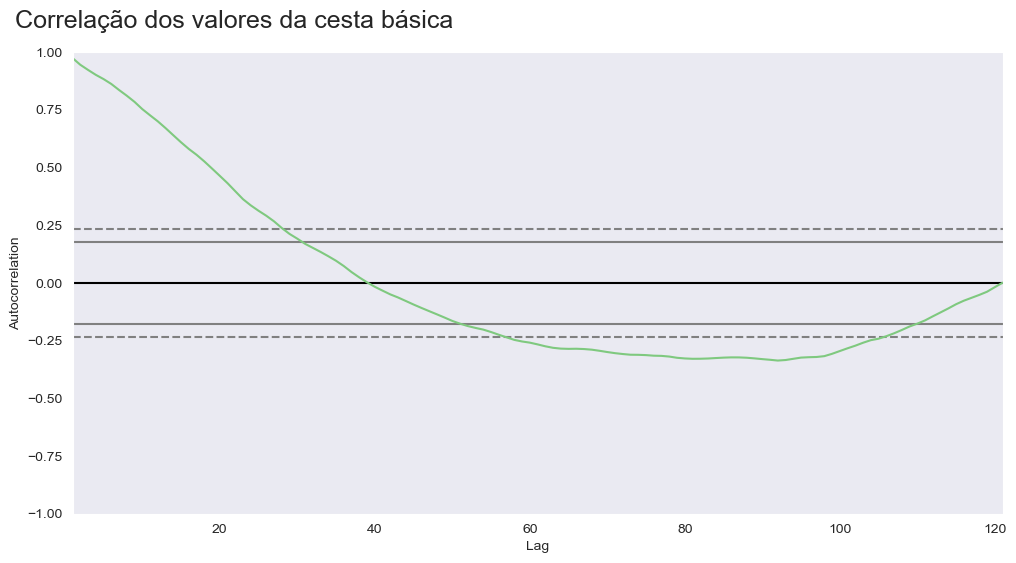

In [10]:
ax = plt.figure(figsize=(12,6))
ax.suptitle('Correlação dos valores da cesta básica', fontsize=18, x=0.26, y=0.95) 
autocorrelation_plot(df_deflacionado['valor'])
ax=ax

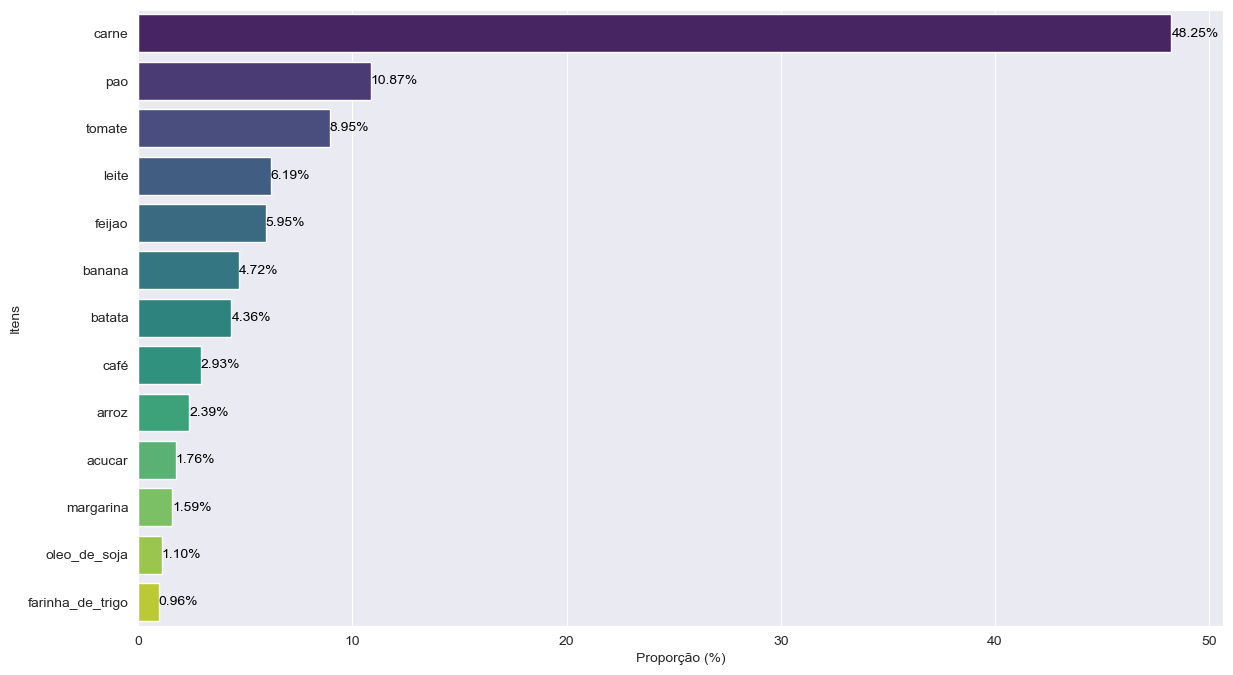

In [11]:
# Criar DataFrame vazio para armazenar as proporções de cada item
df_deflacionado_proporcao = pd.DataFrame()

# Calcular a proporção de cada item em relação ao valor total da cesta básica
for coluna in colunas:
    df_deflacionado_proporcao[coluna] = df_deflacionado[coluna] / df_deflacionado['valor']

# Calcular a média da proporção de cada item em porcentagem
proporcao_media_porcentagem = df_deflacionado_proporcao.mean() * 100

# Criar um DataFrame com as proporções médias de cada item em porcentagem
df_proporcao_media_porcentagem = pd.DataFrame(proporcao_media_porcentagem, columns=['Proporção Média (%)'])

# Ordenar o DataFrame pela proporção média em ordem decrescente
df_proporcao_media_porcentagem = df_proporcao_media_porcentagem.sort_values(by='Proporção Média (%)', ascending=False)

# Plotar o gráfico de barras para visualizar as proporções médias de cada item
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x=df_proporcao_media_porcentagem['Proporção Média (%)'], y=df_proporcao_media_porcentagem.index, palette='viridis')
plt.xlabel('Proporção (%)')
plt.ylabel('Itens')

# Adicionar porcentagens ao lado de cada barra
for index, value in enumerate(df_proporcao_media_porcentagem['Proporção Média (%)']):
    barplot.text(value, index, f'{value:.2f}%', ha='left', va='center', color='black', fontsize=10)

plt.show()

Text(0.5, 1.0, 'Distribuição dos PREÇOS')

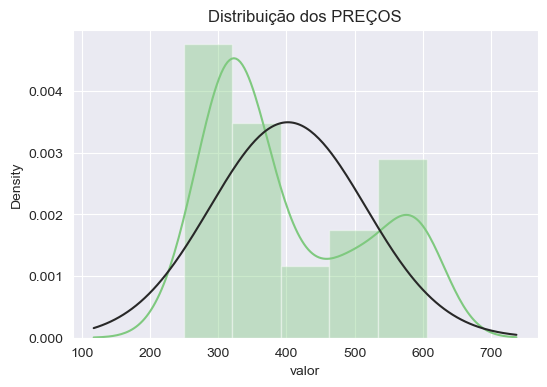

In [12]:
#analisando a distribuição dos preços
plt.figure(figsize=(6,4))
ax = sns.distplot(df_deflacionado['valor'],
                  fit=norm,
                  kde=True)
ax.set_xlabel('valor')
ax.set_title('Distribuição dos PREÇOS')

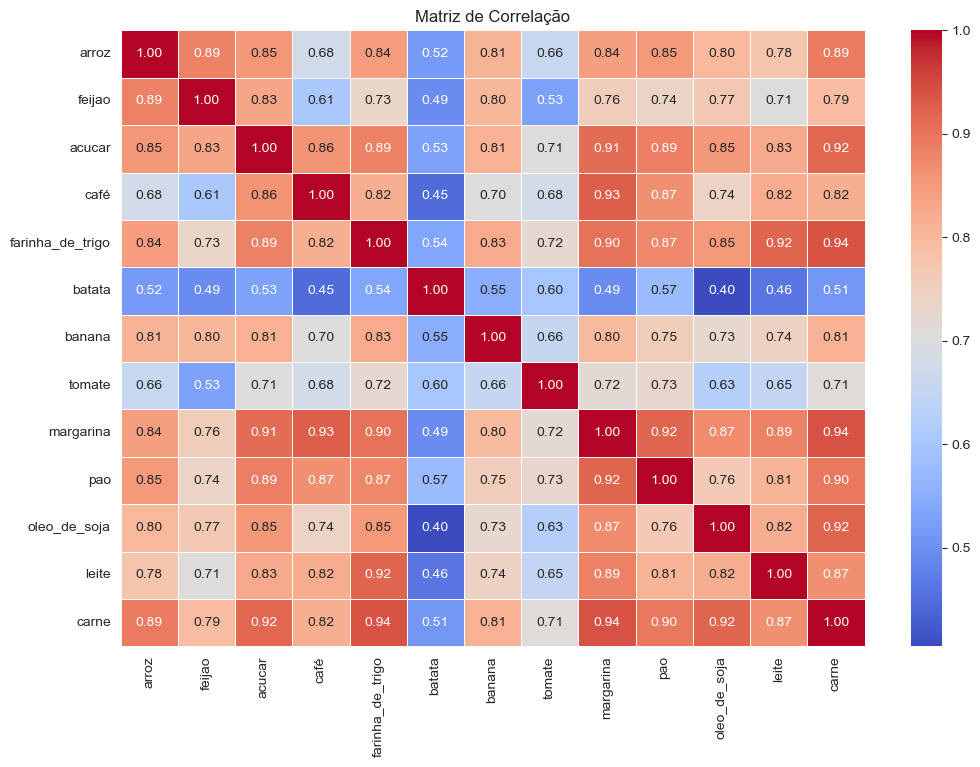

In [13]:
# Selecionando apenas as colunas desejadas para o cálculo da matriz de correlação
colunas_selecionadas = [coluna for coluna in df_deflacionado.columns if coluna not in ['data', 'valor']]
correlation_matrix = df_deflacionado[colunas_selecionadas].corr()

# Plotando a matriz de correlação
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação')
plt.show()

In [14]:
def plotar(y1, y2, y3, cor1, cor2, cor3, label1, label2, label3, titulo):
    plt.figure(figsize=(8, 2))
    plt.plot(y1, color=cor1, label=label1)
    plt.plot(y2, color=cor2, label=label2)
    plt.plot(y3, color=cor3, label=label3)
    plt.title(titulo, fontsize=10)
    plt.legend(fontsize=9)

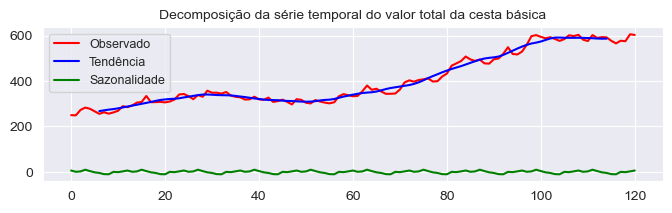

In [15]:
decomposicao = seasonal_decompose(df_deflacionado['valor'], model='additive', period=12)
plotar(decomposicao.observed, decomposicao.trend, decomposicao.seasonal, 'red','blue','green',
      'Observado','Tendência','Sazonalidade', 'Decomposição da série temporal do valor total da cesta básica')

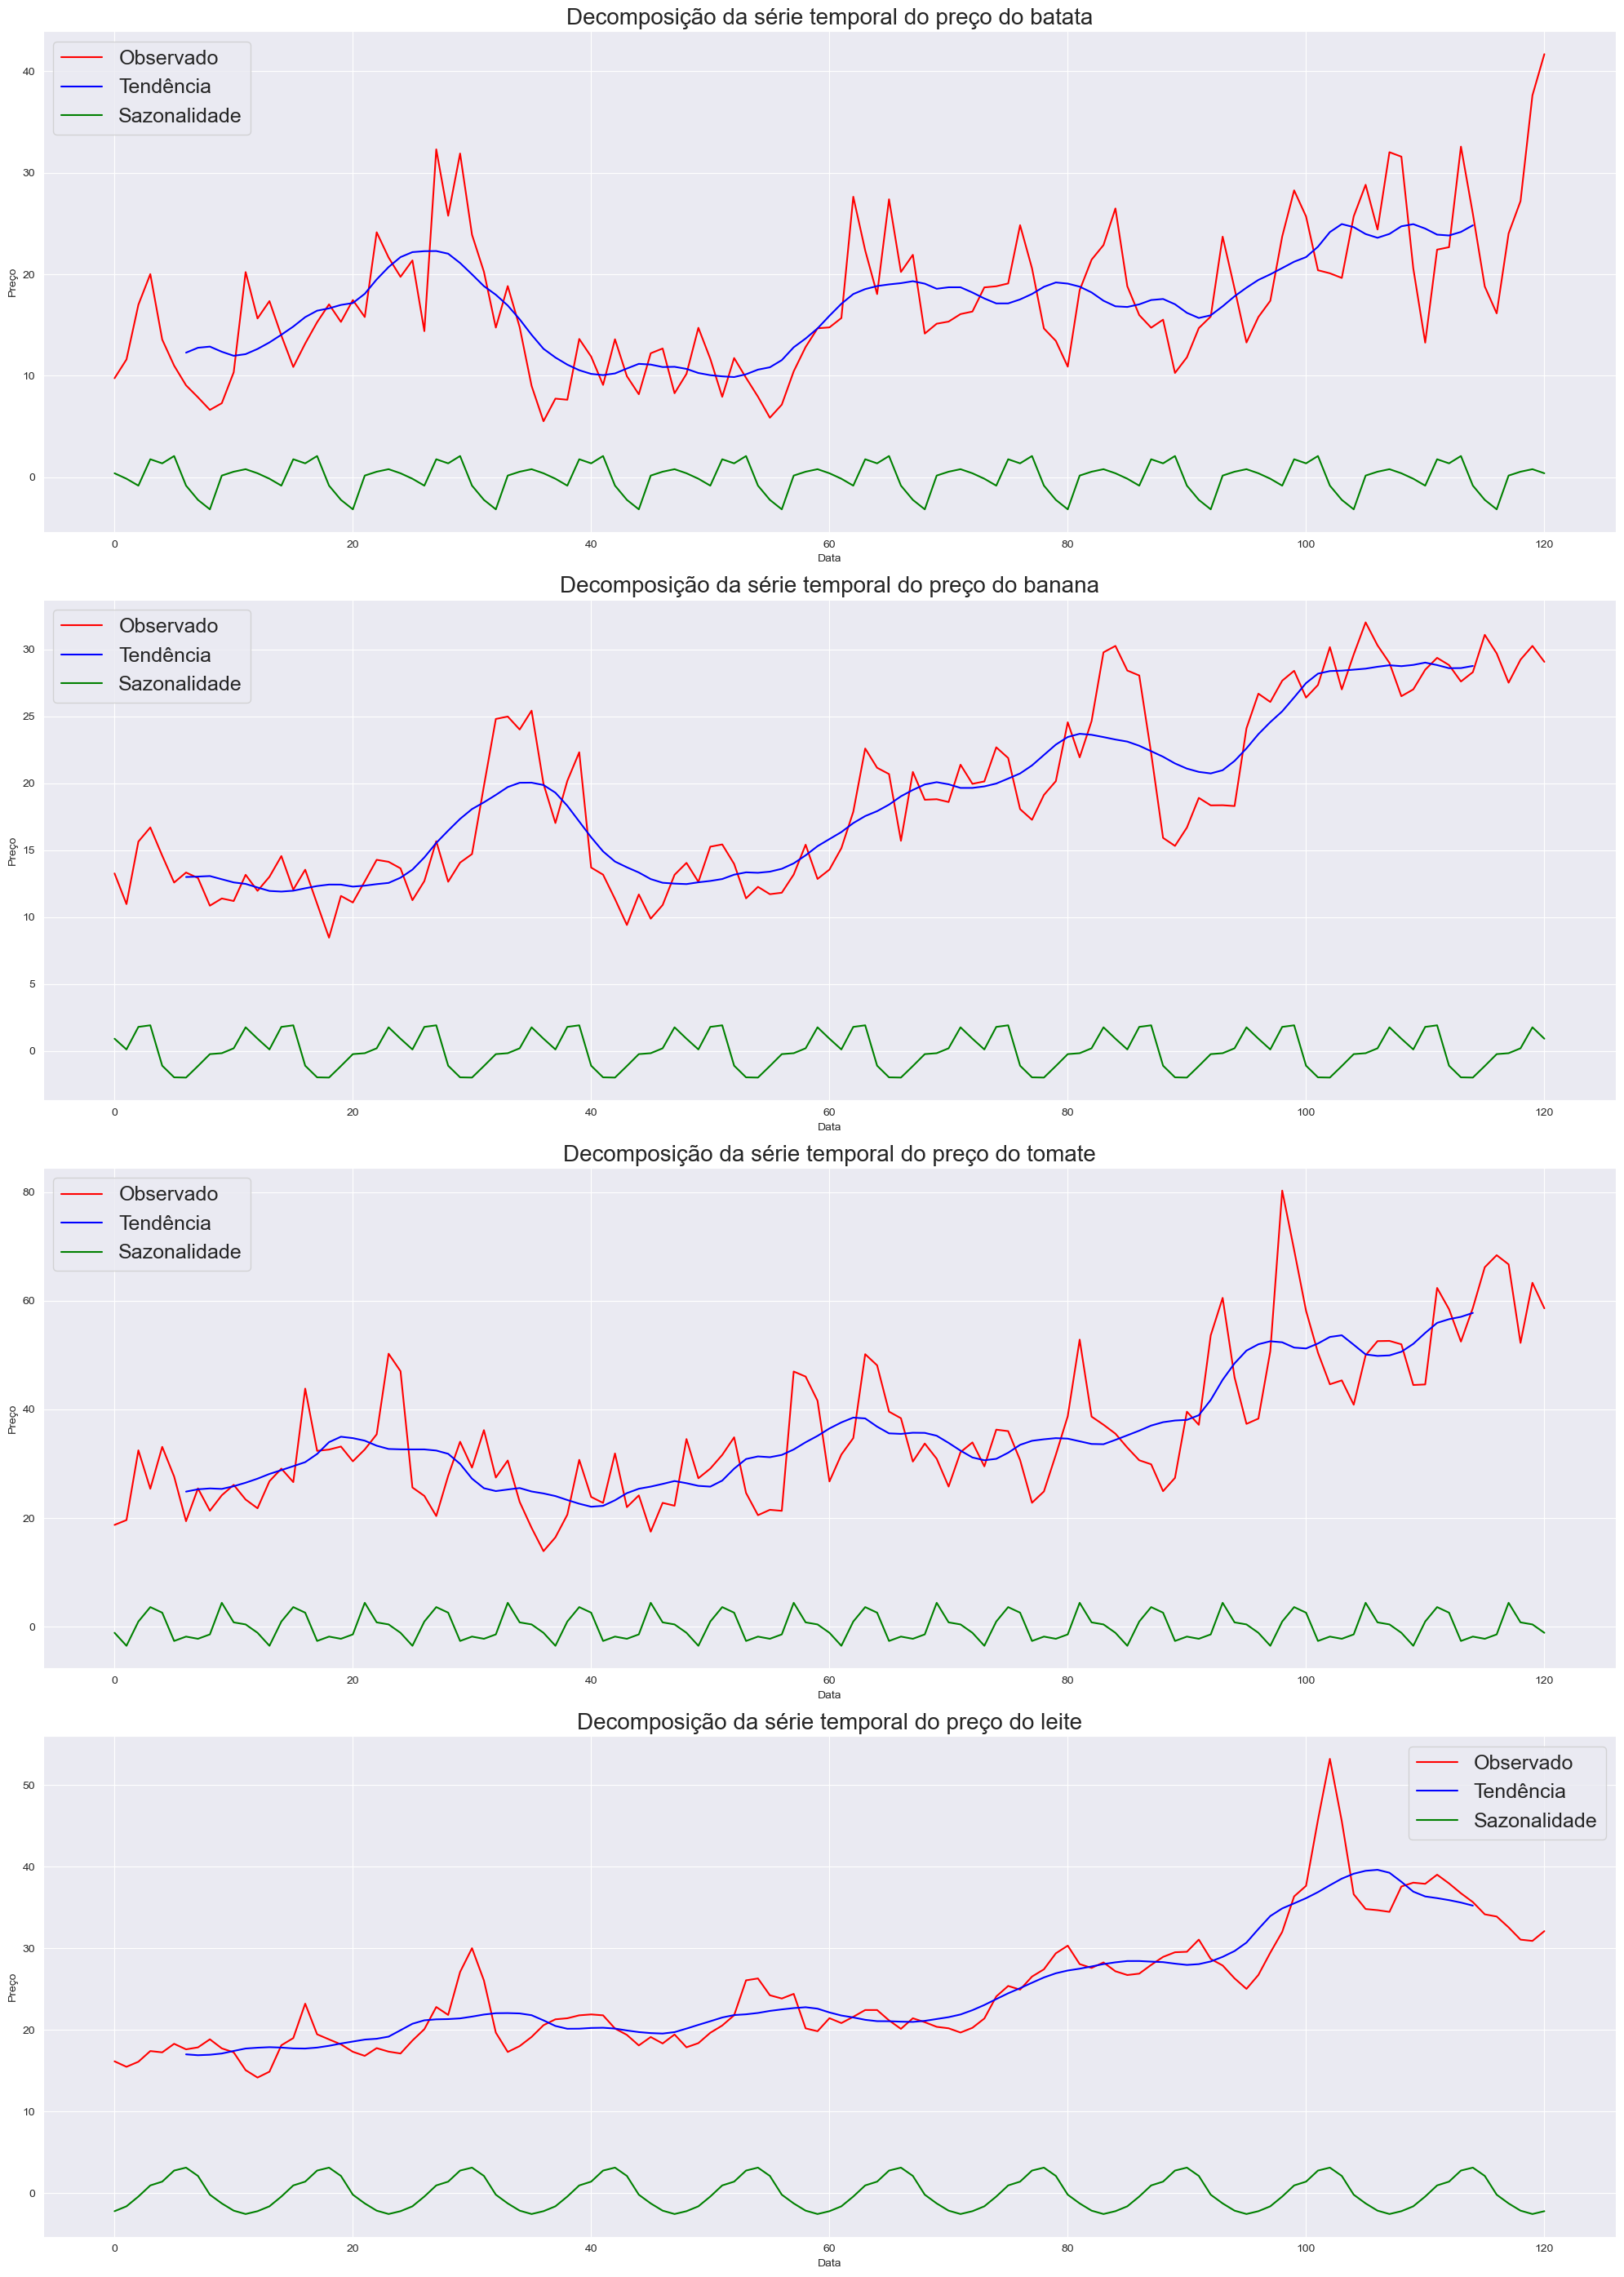

In [16]:
def plotar(y1, y2, y3, cor1, cor2, cor3, label1, label2, label3, titulo):
    plt.plot(y1, color=cor1, label=label1)
    plt.plot(y2, color=cor2, label=label2)
    plt.plot(y3, color=cor3, label=label3)
    plt.title(titulo, fontsize=20)
    plt.legend(fontsize=18)
    plt.xlabel('Data')
    plt.ylabel('Preço')

# Criar subplots
fig, axs = plt.subplots(4, 1, figsize=(20, 28))

# Decomposição e plotagem para cada série temporal
series = ['batata', 'banana', 'tomate', 'leite']
for i, serie in enumerate(series):
    decomposicao = seasonal_decompose(df_deflacionado[serie], model='additive', period=12)

    # Plotar a decomposição
    axs[i].plot(decomposicao.observed, color='red', label='Observado')
    axs[i].plot(decomposicao.trend, color='blue', label='Tendência')
    axs[i].plot(decomposicao.seasonal, color='green', label='Sazonalidade')
    axs[i].set_title(f'Decomposição da série temporal do preço do {serie}', fontsize=20)
    axs[i].legend(fontsize=18)
    axs[i].set_xlabel('Data')
    axs[i].set_ylabel('Preço')

plt.tight_layout()
plt.show()

###Teste de Estacionariedade

In [17]:
y = df_deflacionado['valor']

In [18]:
# Aplicando o teste de Dickey-Fuller para testar a estacionariedade da série
adfuller_preco_medio = adfuller(y)
print('ADF Statistics VALOR:', adfuller_preco_medio[0])
print('p-value VALOR:', adfuller_preco_medio[1])
print(f'Critical Values: {adfuller_preco_medio[4]}')

if adfuller_preco_medio[1] <= 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária.")

ADF Statistics VALOR: -0.1529700280495176
p-value VALOR: 0.9439001970097095
Critical Values: {'1%': -3.486055829282407, '5%': -2.8859430324074076, '10%': -2.5797850694444446}
A série não é estacionária.


In [19]:
y_diff = y.diff().diff().dropna()

resultado_adf_diferenciado = adfuller(y_diff)
print('ADF Estatística (após 2 diferenciações):', resultado_adf_diferenciado[0])
print('Valor-p (após diferenciação):', resultado_adf_diferenciado[1])
    
if resultado_adf_diferenciado[1] <= 0.05:
    print("A série é estacionária")
else:
    print("A série não é estacionária.")

ADF Estatística (após 2 diferenciações): -6.758070430291043
Valor-p (após diferenciação): 2.8381072029157895e-09
A série é estacionária


## ARIMA

In [20]:
df_deflacionado.set_index('data', inplace=True, drop=False)

In [21]:
# Preparação de dados
dados = (
  df_deflacionado
  .filter(items = ["data", "valor"], axis = "columns")
  .assign(
    ano = lambda x: x.data.dt.year,
    mes = lambda x: x.data.dt.month,
    trimestre = lambda x: x.data.dt.quarter,
    valor_lag1 = lambda x: x.valor.shift(1),
    valor_lag2 = lambda x: x.valor.shift(2),
    valor_lag3 = lambda x: x.valor.shift(3),
    tendencia = lambda x: range(-1, x.shape[0] - 1)
    )
  .dropna()
)

dados

,data,valor,ano,mes,trimestre,valor_lag1,valor_lag2,valor_lag3,tendencia
data,,,,,,,,,
2014-04-01,2014-04-01,283.13,2014,4,2,272.89,249.12,249.82,2
2014-05-01,2014-05-01,277.92,2014,5,2,283.13,272.89,249.12,3
2014-06-01,2014-06-01,266.70,2014,6,2,277.92,283.13,272.89,4
2014-07-01,2014-07-01,255.54,2014,7,3,266.70,277.92,283.13,5
2014-08-01,2014-08-01,262.69,2014,8,3,255.54,266.70,277.92,6
...,...,...,...,...,...,...,...,...,...
2023-09-01,2023-09-01,565.43,2023,9,3,576.73,591.86,593.06,115
2023-10-01,2023-10-01,577.02,2023,10,4,565.43,576.73,591.86,116
2023-11-01,2023-11-01,575.08,2023,11,4,577.02,565.43,576.73,117


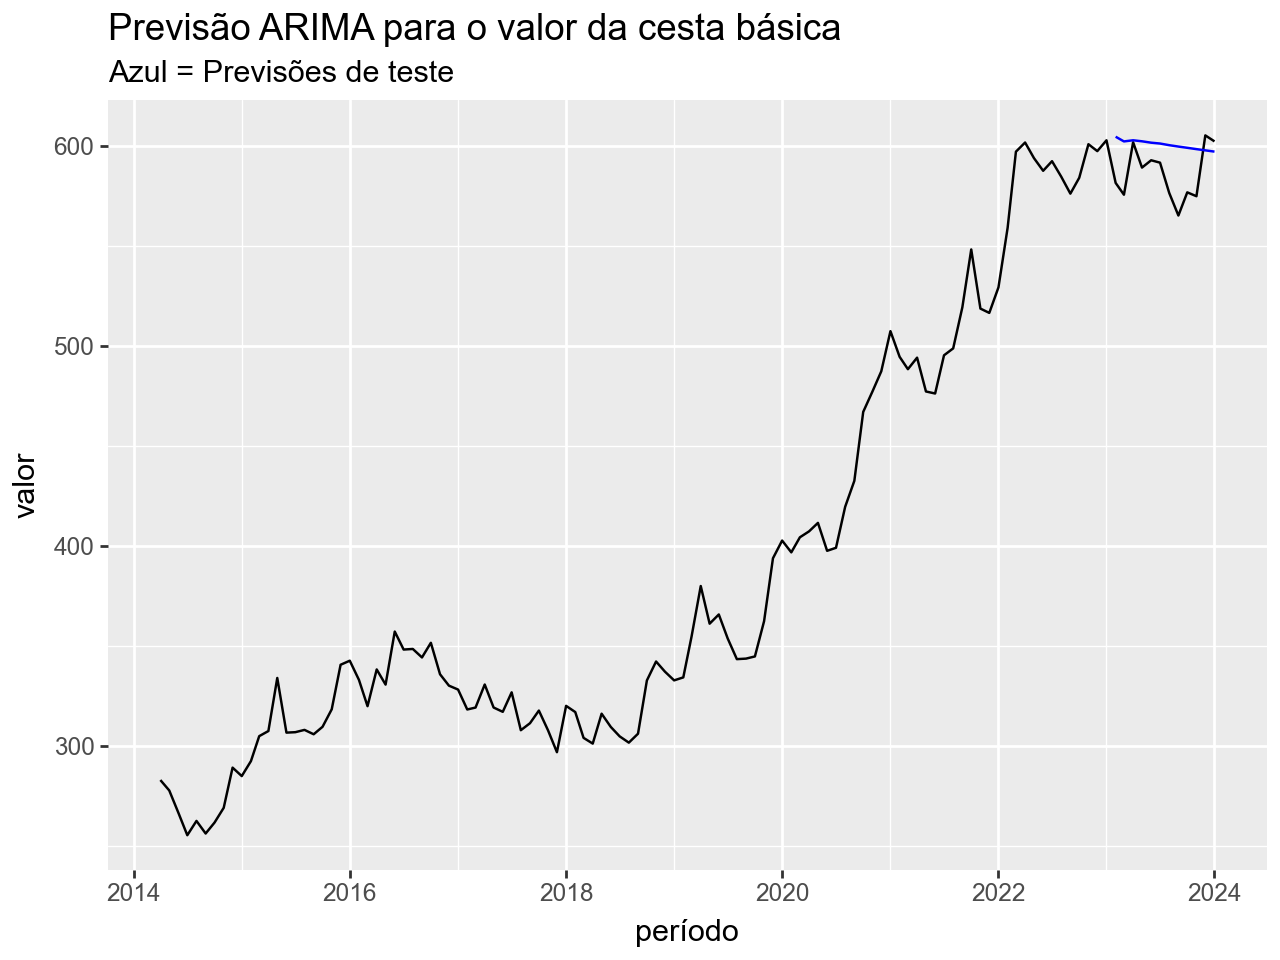

In [22]:
# Aplicar técnica de diferenciação duas vezes para tornar a série estacionária
dados['valor_diff'] = dados['valor'].diff().diff().fillna(0)

# Separar amostras de teste
dados_teste = dados.tail(12).drop(['data', 'valor'], axis="columns")
y_teste = dados_teste['valor_diff']
x_teste = dados_teste.drop(["valor_diff"], axis="columns")

# Separar amostras de treinamento
dados_treino = dados.query("data not in @y_teste.index").drop(['data', 'valor'], axis="columns")
y_treino = dados_treino['valor_diff']
x_treino = dados_treino.drop(["valor_diff"], axis="columns")

# Previsão ARIMA ----

# Estimar modelo
ajuste_arima = pmd.auto_arima(y = y_treino, seasonal = True, m = 12)

# Produzir previsões
previsao_arima_diff = ajuste_arima.predict(y_teste.shape[0])

# Reverter diferenciação duas vezes para obter previsões nos valores originais
previsao_arima = previsao_arima_diff.cumsum().cumsum().fillna(0) + dados['valor'].iloc[-2]

# Criar DataFrame para visualização
resultados_arima = pd.DataFrame({
    "data": dados['data'],
    "valor_original": dados['valor'],
    "previsao_arima": previsao_arima
})

# Gráfico de série temporal e previsões
(
  p9.ggplot(resultados_arima) +
  p9.aes(x = "data", y = "valor_original") +  
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao_arima"), color = "blue") + 
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão ARIMA para o valor da cesta básica",
    subtitle = "Azul = Previsões de teste",
    x = "período",
    y = "valor",
  )
)

## XGBoost

In [23]:
dados.drop(columns=["valor_diff"], inplace=True)

In [24]:
dados_teste

,ano,mes,trimestre,valor_lag1,valor_lag2,valor_lag3,tendencia,valor_diff
data,,,,,,,,
2023-02-01,2023,2,1,603.05,597.63,601.09,108,-26.74
2023-03-01,2023,3,1,581.73,603.05,597.63,109,15.42
2023-04-01,2023,4,2,575.83,581.73,603.05,110,32.15
2023-05-01,2023,5,2,602.08,575.83,581.73,111,-38.93
2023-06-01,2023,6,2,589.40,602.08,575.83,112,16.34
2023-07-01,2023,7,3,593.06,589.40,602.08,113,-4.86
2023-08-01,2023,8,3,591.86,593.06,589.40,114,-13.93
2023-09-01,2023,9,3,576.73,591.86,593.06,115,3.83
2023-10-01,2023,10,4,565.43,576.73,591.86,116,22.89


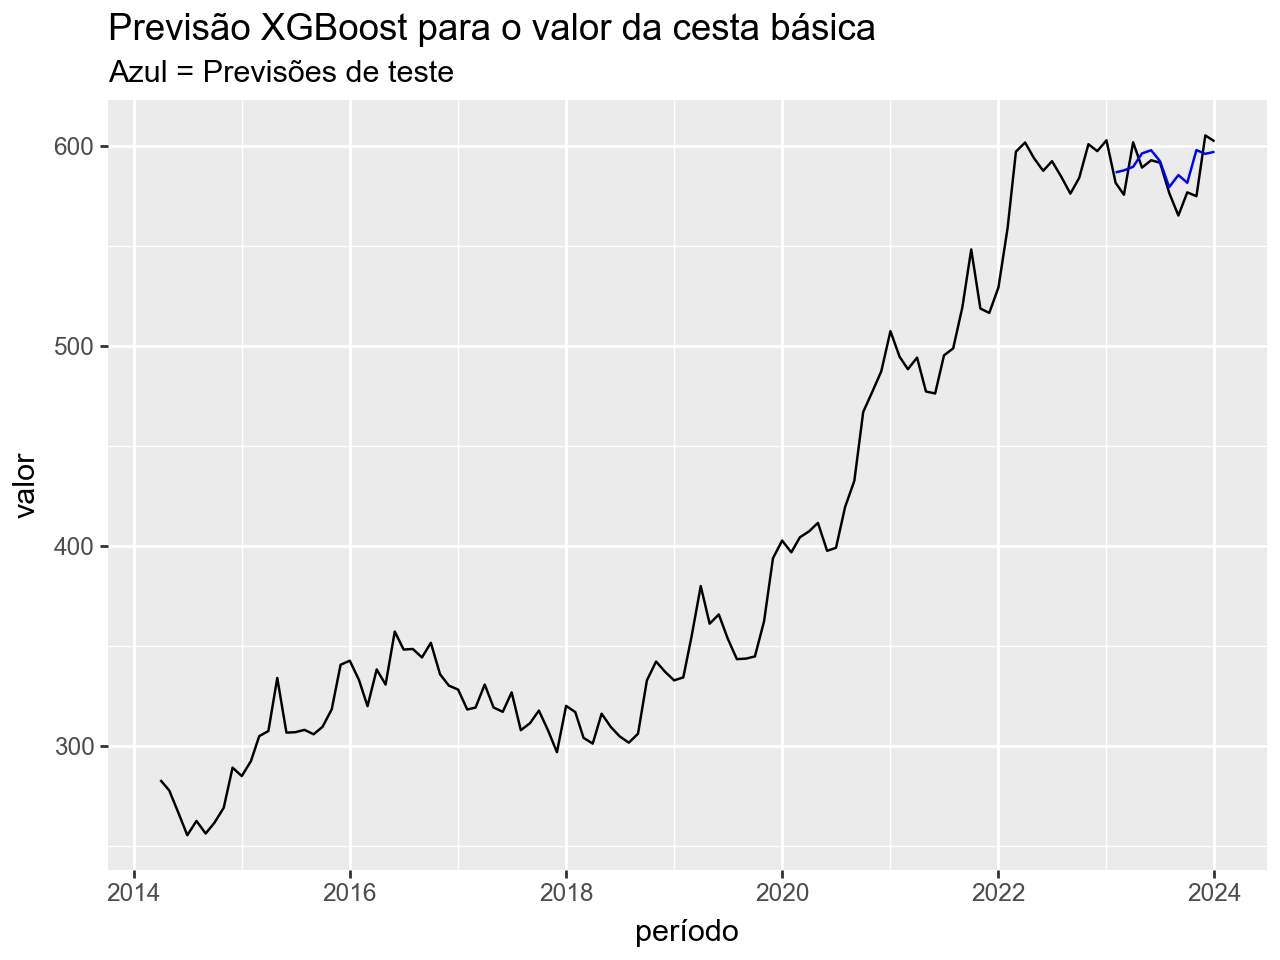

In [25]:
# Separar amostras de teste
dados_teste = dados.tail(12).drop(['data'], axis="columns")

y_teste = dados_teste['valor']
x_teste = dados_teste.drop(["valor"], axis="columns")

# Separar amostras de treinamento
dados_treino = dados.query("data not in @y_teste.index").drop(['data'], axis="columns")
y_treino = dados_treino['valor']
x_treino = dados_treino.drop(["valor"], axis="columns")

# Estimar modelo
ajuste_xgboost = xgb.XGBRegressor().fit(X=x_treino, y=y_treino)

# Produzir previsões
previsao_xgboost = ajuste_xgboost.predict(x_teste)

# Gráfico de valores observados e previstos
resultados_xgboost = pd.DataFrame(
    data={
        "data": dados.data,
        "y": dados.valor,
        "previsao": pd.Series(previsao_xgboost, index=dados_teste.index)
    },
    index=dados.data
)

(
    p9.ggplot(resultados_xgboost) +
    p9.aes(x="data") +
    p9.geom_line(p9.aes(y="y"), color="black") +
    p9.geom_line(p9.aes(y="previsao"), color="blue") +
    p9.scale_x_date(date_breaks="2 years", date_labels="%Y") +
    p9.labs(
        title="Previsão XGBoost para o valor da cesta básica",
        subtitle="Azul = Previsões de teste",
        x="período",
        y="valor",
    )
)

## TimeGPT

In [26]:
df_valor = pd.DataFrame({
    'valor': dados['valor']})

INFO:nixtlats.timegpt:Happy Forecasting! :), If you have questions or need support, please email ops@nixtla.io
INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...
INFO:nixtlats.timegpt:Inferred freq: MS
INFO:nixtlats.timegpt:Calling Forecast Endpoint...


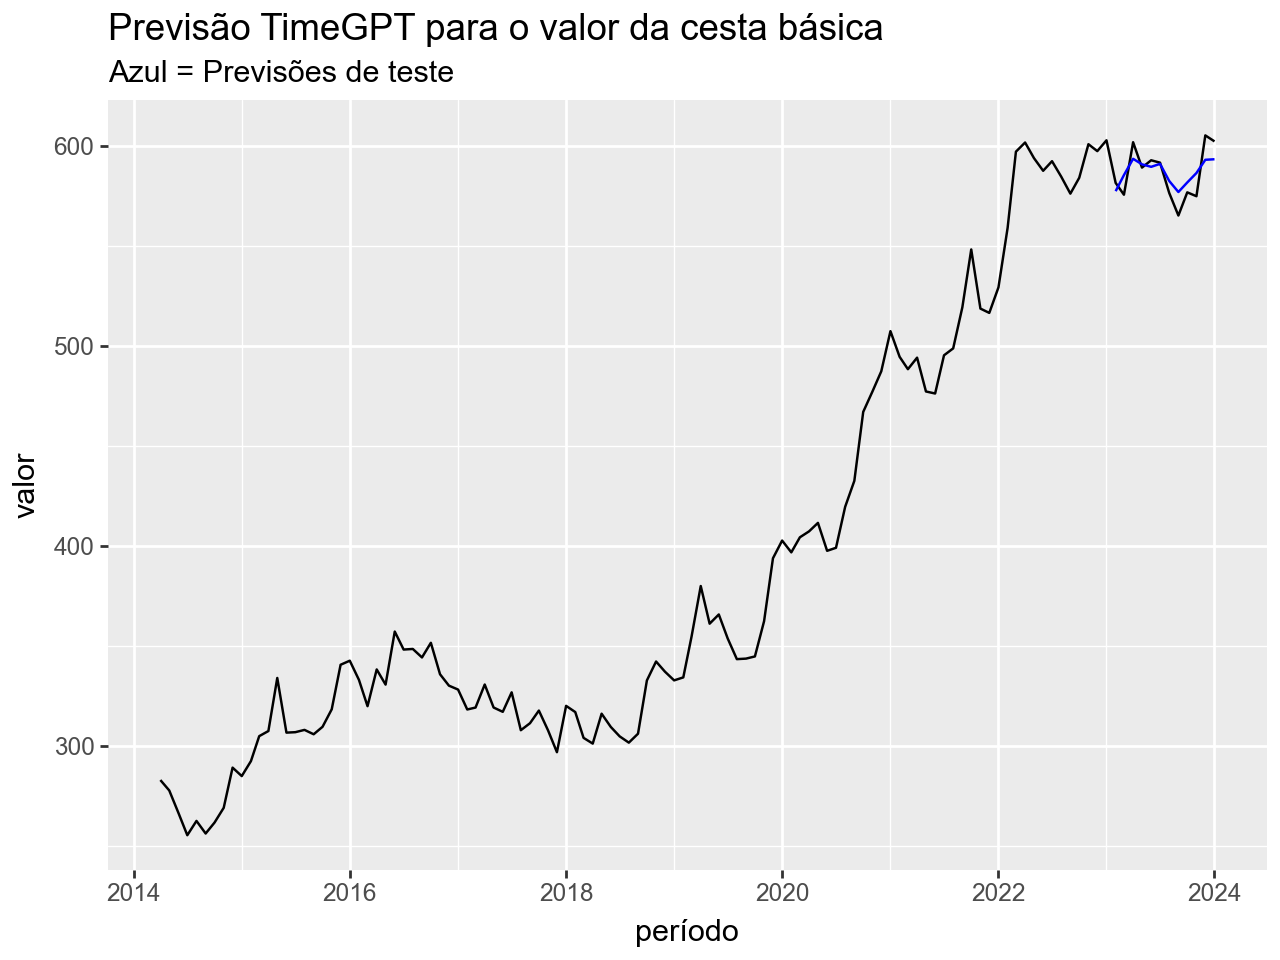

In [27]:
# Previsão TimeGPT

# Autenticação na API

timegpt = TimeGPT(token='XXXXXXXXXXXXXXXXXXXXXXXXX')
timegpt.validate_token()

# Produzir previsões
previsao_timegpt = timegpt.forecast(df=df_valor, h=12, time_col='data', target_col='valor')

# Gráfico de valores observados e previstos
resultados_timegpt = pd.DataFrame(
  data = {
    "data": dados.data,
    "y": dados.valor,
    "previsao": pd.Series(
      previsao_timegpt.TimeGPT.values,
      index = previsao_arima.index
      )
    },
  index = dados.data
)

(
  p9.ggplot(resultados_timegpt) +
  p9.aes(x = "data", y = "y") +
  p9.geom_line() +
  p9.geom_line(mapping = p9.aes(y = "previsao"), color = "blue") +
  p9.scale_x_date(date_breaks = "2 years", date_labels = "%Y") +
  p9.labs(
    title = "Previsão TimeGPT para o valor da cesta básica",
    subtitle = "Azul = Previsões de teste",
    x = "período",
    y = "valor",
  )
)

## Comparando os resultados

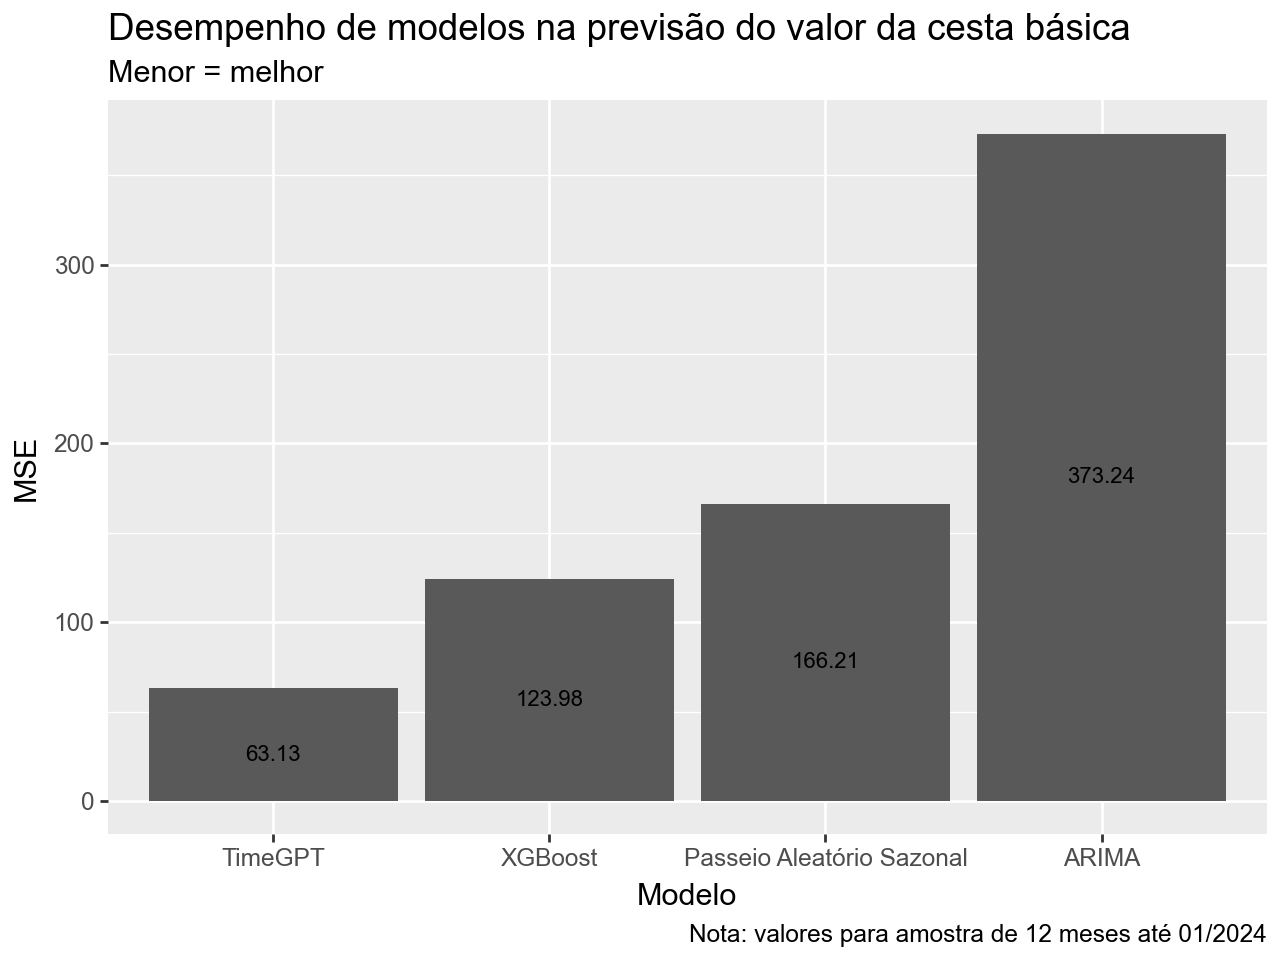

In [28]:
# Comparando resultados ----

# Calculando erros
erro_arima = y_teste - previsao_arima
erro_xgboost = y_teste - previsao_xgboost
erro_timegpt = y_teste - previsao_timegpt.TimeGPT.values
erro_passeio_aleatorio = y_teste - y_treino.tail(12).values

# Calculando métrica MSE
acuracia = pd.DataFrame(
    data={
        "Modelo": ["ARIMA", "XGBoost", "TimeGPT", "Passeio Aleatório Sazonal"],
        "MSE": [
            erro_arima.pow(2).mean(),
            erro_xgboost.pow(2).mean(),
            erro_timegpt.pow(2).mean(),
            erro_passeio_aleatorio.pow(2).mean(),
        ],
    }
).assign(
    Modelo=lambda x: pd.Categorical(
        x.Modelo,
        categories=x.sort_values(by="MSE").Modelo.tolist()
    )
)

# Visualização de dados
(
    p9.ggplot(acuracia) +
    p9.aes(x="Modelo", y="MSE") +
    p9.geom_col() +
    p9.geom_text(p9.aes(label='round(MSE, 2)'), va='top', size=8, position=p9.position_stack(vjust=0.5)) +
    p9.labs(
        title="Desempenho de modelos na previsão do valor da cesta básica",
        subtitle="Menor = melhor",
        caption=(
            "Nota: valores para amostra de 12 meses até " +
            y_teste.index.max().strftime("%m/%Y")
        )
    )
)
